In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from celluloid import Camera
from IPython import display

def twoD_gaussian(mx, my, sigmax, sigmay, n = 20):
  x = np.random.normal(mx, sigmax, n)
  y = np.random.normal(my, sigmay, n)
  return (x, y)

def distance(meanK, point):
  meanK = np.array(meanK)
  point = np.array(point)
  return np.sqrt(sum((meanK-point)**2))

def clustering(mx, my, X, Y, K = 5):
  df = pd.DataFrame()
  df['x'] = X
  df['y'] = Y
  label_list = []
  Loss = 0
  for i in range(len(X)):
    dis = []
    for j in range(K):
      dis.append(distance((mx[j], my[j]), (X[i], Y[i])))
    min_index = dis.index(min(dis));
    label_list.append(min_index + 1)
    Loss += min(dis)
    
  df['label'] = label_list;
  data = []
  for i in range(K):
    data.append(df[df['label'] == i+1].reset_index(drop = True))
  
  return data, Loss

def process(X, Y, K = 5):
  mx, my = twoD_gaussian(0, 0, 7, 7, K);
  data, Loss_i = clustering(mx, my, X, Y, K);
  Loss_i_1 = 1e+10;
  fig = plt.figure(figsize = (8, 8))
  camera = Camera(fig)
  #frames = []
  while Loss_i_1 - Loss_i > 0.001:
    #fig = plt.figure(figsize = (8, 8))
    for i in range(K):
      plt.scatter(data[i]['x'], data[i]['y'], label = 'class' + str(i+1), color = "C" + str(i))
      plt.scatter(mx[i], my[i], marker = ".", linewidth = 25, color = "C" + str(i))
    
    plt.xlabel('x', fontsize = 16)
    plt.ylabel('y', fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    #plt.legend(fontsize = 10);
    camera.snap()
    #plt.legend('',frameon=False)
    #fig.clf()
    #fig = plt.figure(figsize = (8, 8))
    #frames.append([fig])
    #plt.pause(0.001)

    mx = [data[i]['x'].mean() for i in range(K)]
    my = [data[i]['y'].mean() for i in range(K)]

    Loss_i_1 = Loss_i;
    data, Loss_i = clustering(mx, my, X, Y, K);

  animation = camera.animate(1000)
  animation.save('c21.gif', writer = 'pillow')

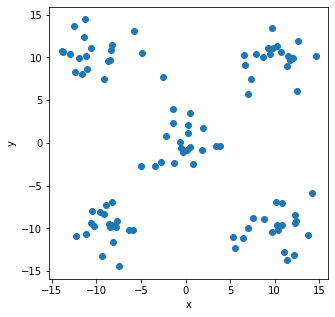

In [19]:
x1, y1 = twoD_gaussian(0, 0, 2, 2);
x2, y2 = twoD_gaussian(10, 10, 2, 2);
x3, y3 = twoD_gaussian(-10, -10, 2, 2);
x4, y4 = twoD_gaussian(10, -10, 2, 2);
x5, y5 = twoD_gaussian(-10, 10, 2, 2);

X = np.concatenate((x1,x2,x3,x4,x5))
Y = np.concatenate((y1,y2,y3,y4,y5))
plt.figure(figsize = (5, 5))
plt.scatter(X, Y);
plt.xlabel('x');
plt.ylabel('y');

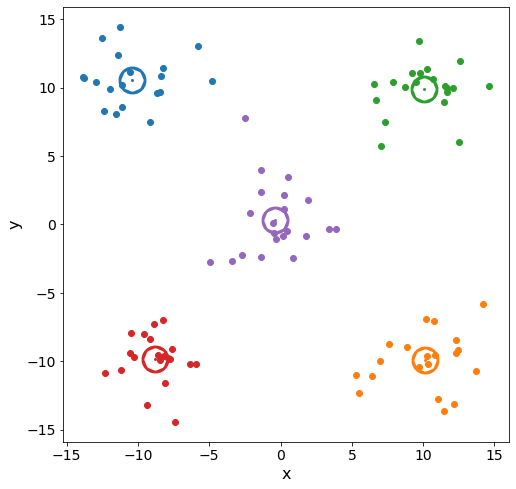

In [20]:
process(X, Y)

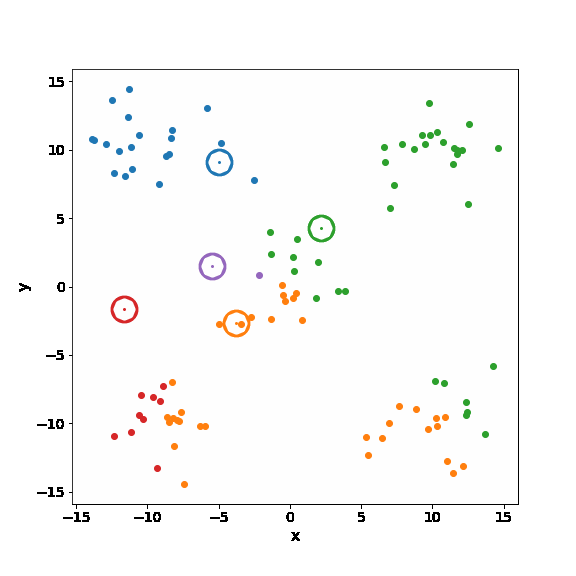

In [21]:
from IPython import display

display.Image(open('c21.gif', 'rb').read())

In [ ]:
meanK = np.array((2, 3))
point = np.array((10, 40));
xx = meanK - point
xx1 = xx**2
np.sqrt(sum(xx1))

37.8549864614954

## Fuzzy C- Means (FCM)

In [84]:
def dist(data, c):
  arr1 = np.zeros((data.shape[0],))
  arr1 = np.expand_dims(arr1, axis=0)

  for k in range(c.shape[0]):
    dst = (data - c[k])**2;
    dst = sum(dst.T); #distance between point and cluster  === N
    dst = np.expand_dims(dst, axis = 0); # === 1*N
    arr1 = np.append(arr1, dst, axis = 0); # === appending each cluster distances from all data points

  arr1 = np.delete(arr1, 0, axis = 0); # deleting first zeros row defined earlier === K*N
  return arr1.T  # shape == N*K

In [150]:
def FCM(data, K, q):
  Loss_i_1 = 1e+10;
  mx, my = twoD_gaussian(0, 0, 7, 7, K);
  mx = np.expand_dims(mx, axis = 0)
  my = np.expand_dims(my, axis = 0)
  c = np.append(mx, my, axis = 0);
  c = c.T
  z = 0;
  mu = np.ones((data.shape[0], K));
  mu = mu*(1/K);
  # mu_i_1 = np.ones((data.shape[0], K))
  # mu_i_1 = mu_i_1*(1/100)

  Loss_i = sum(sum(np.multiply(dist(data, c), mu**q)))
  while Loss_i_1 - Loss_i > 0.001:
    #mu_i_1 = mu
    ##### d[j][k] = distance between cluster and point (data_j - c_k)^2
    ##### d ------>>> N*K
    d = dist(data, c);
    d1 = d**(1/(q-1));
    d1_norm = sum(d1.T) # 1*N
    
    ##### data ------>>> N*2
    ##### mu = weight membership for each data point assigned to each class from 1 to K
    ##### mu ----->>> N*K
    ##### q = power assigned to membership
    mu = d1.T/d1_norm # K*N
    mu = mu.T  # N*K
    mu1 = mu**q;

    ##### sm = multiplication of matrix mu^2 Transpose and original data 
    ##### sm ------>>> (K*N)**(N*2) === (K*2)
    sm = np.matmul(mu1.T, data);

    ##### sm_norm = total sum of membership weights (sum over all data points N) with their power for each cluster
    ##### sm_norm ---->>> 1*K or K
    sm_norm = sum(mu1);

    ##### c = cluster mean points and total K points in 2D
    ##### c ----->>> K*2
    c1 = sm.T/sm_norm; 
    c = c1.T # K*2

    Loss_i_1 = Loss_i;
    Loss_i = sum(sum(np.multiply(dist(data, c), mu1))) 
  return c

(100, 2)


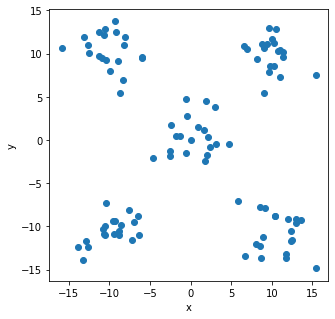

In [148]:
x1, y1 = twoD_gaussian(0, 0, 2, 2);
x2, y2 = twoD_gaussian(10, 10, 2, 2);
x3, y3 = twoD_gaussian(-10, -10, 2, 2);
x4, y4 = twoD_gaussian(10, -10, 2, 2);
x5, y5 = twoD_gaussian(-10, 10, 2, 2);

X = np.concatenate((x1, x2,x3,x4,x5))
Y = np.concatenate((y1, y2,y3,y4,y5))
X = np.expand_dims(X, axis = 0)
Y = np.expand_dims(Y, axis = 0)
data = np.append(X, Y, axis = 0);
data = data.T
print(data.shape)
plt.figure(figsize = (5, 5))
plt.scatter(data.T[0], data.T[1]);
plt.xlabel('x');
plt.ylabel('y');

In [175]:
c = FCM(data, K = 5, q = 1.2)

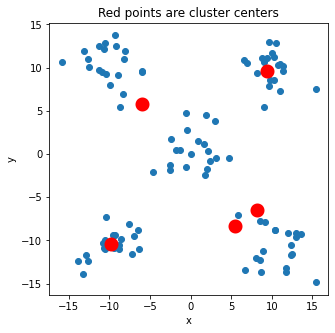

In [176]:
plt.figure(figsize = (5, 5))
plt.scatter(data.T[0], data.T[1]);
plt.scatter(c.T[0], c.T[1], color = 'r', linewidth = 8)
plt.xlabel('x');
plt.ylabel('y');
plt.title("Red points are cluster centers");

## Rough Work

In [ ]:
mx, my = twoD_gaussian(0, 0, 7, 7, K);

In [57]:
mu = np.array([[0.1, 0.4, 0.5], [0.3, 0.2, 0.5], [0.6, 0.1, 0.3], [0.5, 0.4, 0.1], [0.1, 0.1, 0.8]]);
mu1 = mu**2
print('mu1 is: ', mu1)
print('mu1 shape: ', mu1.shape)
print('mu1 Transpose: ', mu1.T)
y = np.array([[5, 5], [1, 1], [8, 1], [2, 0], [9, 1]])
K = 3
N = len(X)
sm = np.zeros((K,2));

for j in range(len(mu)):
  for k in range(K):
    sm[k] += mu1[j][k]*y[j]

sm_norm = sum(mu1);
sm1 = np.matmul(mu1.T, y)
print('mu1.T*y = sum: ', sm)
print('sum_norm:, ', sm_norm)
print('sum1 using matrix mul: ', sm1)
print('mu1.T.shape: ', mu1.T.shape)
print('y.shape: ', y.shape)

mu1 is:  [[0.01 0.16 0.25]
 [0.09 0.04 0.25]
 [0.36 0.01 0.09]
 [0.25 0.16 0.01]
 [0.01 0.01 0.64]]
mu1 shape:  (5, 3)
mu1 Transpose:  [[0.01 0.09 0.36 0.25 0.01]
 [0.16 0.04 0.01 0.16 0.01]
 [0.25 0.25 0.09 0.01 0.64]]
mu1.T*y = sum:  [[3.61 0.51]
 [1.33 0.86]
 [8.   2.23]]
sum_norm:,  [0.72 0.38 1.24]
sum1 using matrix mul:  [[3.61 0.51]
 [1.33 0.86]
 [8.   2.23]]
mu1.T.shape:  (3, 5)
y.shape:  (5, 2)


In [58]:
c = sm1.T/sm_norm
c = c.T
c

array([[5.01388889, 0.70833333],
       [3.5       , 2.26315789],
       [6.4516129 , 1.7983871 ]])

In [60]:
d = np.array([[0.1, 0.4, 0.5], [0.3, 0.2, 0.5], [0.6, 0.1, 0.3], [0.5, 0.4, 0.1], [0.1, 0.1, 0.8]]);
d1 = d**2
d1_norm = sum(d1.T)
mu = d1.T/d1_norm
mu

array([[0.02380952, 0.23684211, 0.7826087 , 0.5952381 , 0.01515152],
       [0.38095238, 0.10526316, 0.02173913, 0.38095238, 0.01515152],
       [0.5952381 , 0.65789474, 0.19565217, 0.02380952, 0.96969697]])

In [83]:
data = np.array([[5, 5], [1, 1], [8, 1], [2, 0], [9, 1]])
c = np.array([[3, 3],[0.5, 1.5]])
arr1 = np.zeros((5,))
arr1 = np.expand_dims(arr1, axis=0)
#arr1 = np.array([[]])
for k in range(c.shape[0]):
  data1 = data - c[k]
  data1 = data1**2
  print(data1)
  data1 = sum(data1.T)
  print(data1)
  data1 = np.expand_dims(data1, axis=0)
  arr1 = np.append(arr1, data1, axis = 0)
arr1 = np.delete(arr1, 0, axis = 0)
arr1

[[ 4.  4.]
 [ 4.  4.]
 [25.  4.]
 [ 1.  9.]
 [36.  4.]]
[ 8.  8. 29. 10. 40.]
[[20.25 12.25]
 [ 0.25  0.25]
 [56.25  0.25]
 [ 2.25  2.25]
 [72.25  0.25]]
[32.5  0.5 56.5  4.5 72.5]


array([[ 8. ,  8. , 29. , 10. , 40. ],
       [32.5,  0.5, 56.5,  4.5, 72.5]])

In [32]:
print(mu1)
print(sum(mu1))

[[0.01 0.16 0.25]
 [0.09 0.04 0.25]]
[0.1 0.2 0.5]


In [30]:
y1 = np.array([0.8, 0.8])
y1 += mu1[0][1]*y[0]
y1

array([1.6, 1.6])

In [39]:
x = np.array([0, 2, 3, 3, 4])
y = np.array([1, 2, 3, 4, 1])
y1 = np.array([[1], [2], [3], [4], [1]])
z = np.dot(x, y)
z1 = np.matmul(x, y)
z2 = np.matmul(y, x)
z0 = np.dot(x, y1)
z11 = np.matmul(x, y1)
#z21 = np.matmul(y1, x)
print(z)
print(z1)
print(z2)
print(z0)
print(z11)
#print(z21)

29
29
29
[29]
[29]
